# Lab 4-6: Mixture Models+Model orden selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before November 21 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_sparse_spd_matrix
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [26]:
class my_GMM():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X, initialization = 'random', tol = 10**-6, it_max = 100):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n, p = X.shape
        k = self.k
        if initialization == 'random' :
            self.mu_ = 1- 2 * np.random.rand(k, p)
            self.Sigma_ = np.zeros((k, p, p))
            for i in range(k) :
                self.Sigma_[i, :] = make_sparse_spd_matrix(p)
            self.alpha_ = np.random.rand(k)
            self.alpha_ = self.alpha_/np.sum(self.alpha_)
        
        self.cond_prob_ = np.zeros((n, k))
            
        # TODO:
        # initialize the parameters
        # apply sklearn kmeans or randomly initialize them
        
        it = 0
        convergence = False
        
        while not convergence :
            density = np.zeros((n, k))
            for i in range (k):
                density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])

            cond_prob_ = self.alpha_.T * density
            self.log_likelelyhood = np.log(np.sum(cond_prob_,axis=1))
            cond_prob_ = cond_prob_ / np.expand_dims(np.sum(cond_prob_, axis = 1), axis = 1)
            delta_cond_prob = np.max(np.abs(self.cond_prob_ - cond_prob_))
            self.cond_prob_ = cond_prob_ 
            
            alpha_ = np.mean(self.cond_prob_, axis = 0)
            delta_alpha = np.max(np.abs(self.alpha_ - alpha_))
            self.alpha_ = alpha_
                                 
            mu_ = (1/self.alpha_)[:, np.newaxis] * np.mean(np.expand_dims(X, axis = 1) * self.cond_prob_[:, :, np.newaxis], axis = 0)
            delta_mu_ = np.max(np.abs(self.mu_ - mu_))
            self.mu_ = mu_
            
            tmp = np.expand_dims(X, axis=1) - np.expand_dims(self.mu_, axis = 0)
            Sigma_ = (1/self.alpha_)[:, np.newaxis, np.newaxis] * np.mean(self.cond_prob_[:, :, np.newaxis, np.newaxis ] * np.matmul(np.expand_dims(tmp, -1), np.expand_dims(tmp, 2)),
                                              axis = 0)
            delta_sigma = np.max(np.abs(self.Sigma_ - Sigma_))
            self.Sigma_ = Sigma_
            it = it + 1
            err = delta_alpha + delta_cond_prob + delta_mu_ + delta_sigma
            if it > it_max or (err < tol) :
                convergence  = True
        print("Fin du fitting à l'iteration :", it , '. Error : ', err)
        self.labels_ = np.argmax(self.cond_prob_, axis = 1)   

    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        cond_prob_ = self.compute_proba(X)
        
        return np.argmax(cond_prob_, axis = 1)
        
        
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n = X.shape[0]
        density = np.zeros((n, k))
        for i in range (k):
            density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])

        cond_prob_ = self.alpha_.T * density
        cond_prob_ = self.cond_prob_ / np.sum(self.cond_prob_, axis = 1)
        return cond_prob_

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [3]:
## Génération d'une mixture de k gaussiennes
k = 4
p = 2
np.random.seed(1)
list_of_x = []
labels = []
for i in range(k) :
    n_i = np.random.randint(100, 1000)
    mu_i = (i+1) * (1 - 2* np.random.rand(p))
    vec_cov_i = np.random.rand(p, p)
    cov_i = np.dot(vec_cov_i, vec_cov_i.T)
    x_i = np.random.multivariate_normal(mu_i, cov_i, n_i)
    list_of_x.append(x_i)
    labels.append(i * np.ones(n_i))
X = np.concatenate(list_of_x)
labels = np.concatenate(labels)
shuffle = np.arange(len(X))
np.random.shuffle(shuffle)
X = X[shuffle]
labels = labels[shuffle]  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log


Fin du fitting à l'iteration : 49 . Error :  8.184464217464438e-11


Text(0.5, 1.0, 'k means predicted labels')

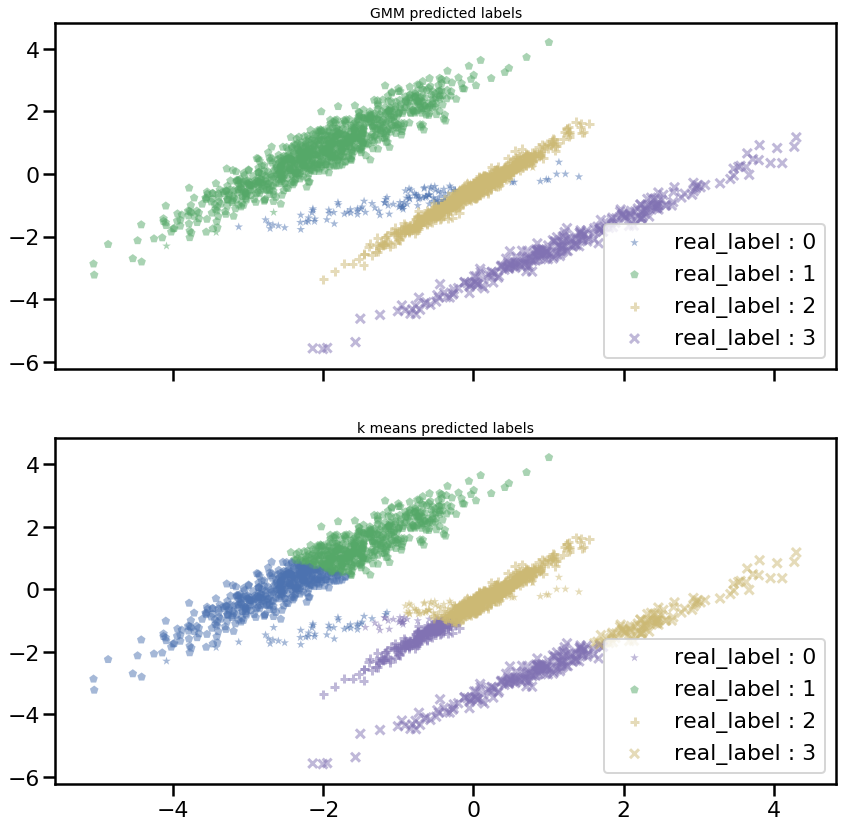

In [4]:
##Fitting et comparaison avec d'autres modèles
np.random.seed(0)
model = my_GMM(k)
model.fit(X, it_max = 1000, tol = 10**-10);

kmeans = KMeans(n_clusters=4, max_iter=200).fit(X)
fig, ax = plt.subplots(2,1, figsize =(14, 14), sharex = True, sharey = True)
marker_style = ['*','p','+', 'x']
color_map = ['b' , 'g', 'y', 'm']

for label_gt in range(k):
    labels_pred = model.labels_[np.where(labels==label_gt)]
    color_labels_pred = [color_map[i] for i in labels_pred]
    ax[0].scatter(X[:, 0].T[np.where(labels==label_gt)], X[:, 1].T[np.where(labels==label_gt)],
                  c=color_labels_pred, marker=marker_style[label_gt],
                   **plot_kwds, label= 'real_label : {}'.format(label_gt))
    labels_pred = kmeans.labels_[np.where(labels==label_gt)]
    color_labels_pred = [color_map[i] for i in labels_pred]
    ax[1].scatter(X[:, 0].T[np.where(labels==label_gt)], X[:, 1].T[np.where(labels==label_gt)],
                  c=color_labels_pred, marker=marker_style[label_gt],
                   **plot_kwds, label= 'real_label : {}'.format(label_gt))

ax[0].legend()
ax[1].legend()
ax[0].set_title('GMM predicted labels', size = 14);
ax[1].set_title('k means predicted labels', size = 14)

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
- Implement the information criterions from the lecture (AIC, BIC, etc.) to select the number of clusters:

### Informations criterions 
#### AIC critetion

In [33]:
def compute_AIC(k): 
    model = my_GMM(k)
    model.fit(X, it_max = 5000, tol = 10**-10);
    number_parameters = k * (model.mu_.shape[1] + 1 + model.mu_.shape[1] * (model.mu_.shape[1] + 1) / 2 ) - 1
    return (np.sum(model.log_likelelyhood) -  number_parameters)

Fin du fitting à l'iteration : 2 . Error :  0.0
Fin du fitting à l'iteration : 79 . Error :  4.4130449294854657e-11
Fin du fitting à l'iteration : 42 . Error :  5.051820073376234e-11
Fin du fitting à l'iteration : 60 . Error :  5.973643801837625e-11
Fin du fitting à l'iteration : 808 . Error :  9.81781843323315e-11
Fin du fitting à l'iteration : 908 . Error :  9.261570893884241e-11
Fin du fitting à l'iteration : 5001 . Error :  4.4300957749432435e-08


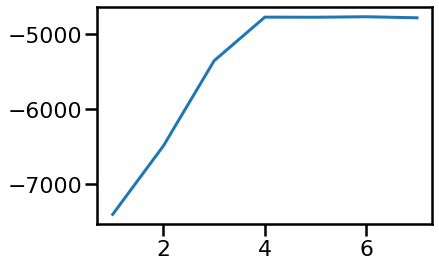

In [52]:
AICs = []
np.random.seed(42)
for k in range(1,8): 
    AICs.append(compute_AIC(k))
plt.plot(range(1,8), AICs)

In [53]:
AICs

[-7400.750292698796,
 -6486.831478272355,
 -5351.961764529058,
 -4770.299508187333,
 -4771.646484704748,
 -4765.008343465515,
 -4779.059356338512]

In [56]:
np.argmax(AICs)

5

#### BIC Criterion

In [43]:
def compute_BIC(k): 
    model = my_GMM(k)
    model.fit(X, it_max = 5000, tol = 10**-10);
    number_parameters = k * (model.mu_.shape[1] + 1 + model.mu_.shape[1] * (model.mu_.shape[1] + 1) / 2 ) - 1
    return (np.sum(model.log_likelelyhood) -   X.shape[0] * number_parameters/ 2)

Fin du fitting à l'iteration : 2 . Error :  0.0
Fin du fitting à l'iteration : 34 . Error :  8.78699890627388e-11
Fin du fitting à l'iteration : 43 . Error :  4.205713555194279e-11
Fin du fitting à l'iteration : 58 . Error :  6.716405209772347e-11
Fin du fitting à l'iteration : 386 . Error :  9.769882125532092e-11
Fin du fitting à l'iteration : 226 . Error :  8.352688289289811e-11
Fin du fitting à l'iteration : 406 . Error :  9.24442189464969e-11


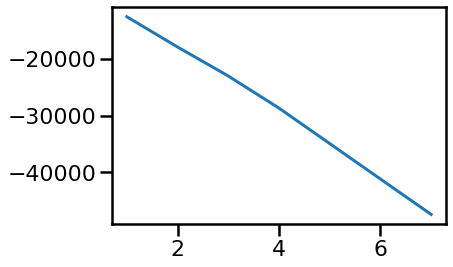

In [55]:
BICs = []
np.random.seed(1)
for k in range(1,8): 
    BICs.append(compute_BIC(k))
plt.plot(range(1,8), BICs)

- Implement the merge criterions 
    - Correlation coefficients
    - Measuring Error 
    - Comparing the parameters

- Implement cross-validation 

In [7]:
# TODO

Use the model selection criterions to choose the number of clusters for the two given datasets (data-MM-i.csv). Compare the results and the computational time. Try to visually validate your results.

In [18]:
import pandas as pd
dataset1 = pd.read_csv('data_MM_1-1.csv',header = None)
dataset1

,0,1,2
0,-0.252340,-0.656972,-0.264355
1,2.482155,2.625767,3.186812
2,3.289949,3.127916,4.322373
3,-0.189123,1.146044,0.017387
4,2.614011,2.868579,3.311365
5,2.975459,2.391604,2.057288
6,-0.072833,-0.982322,-0.186180
7,2.551125,2.268029,3.327089
8,3.718951,3.154302,3.087056
9,-0.280337,0.091934,0.159450


## Application

You are going to work with the following data:

shape: (1797, 64)


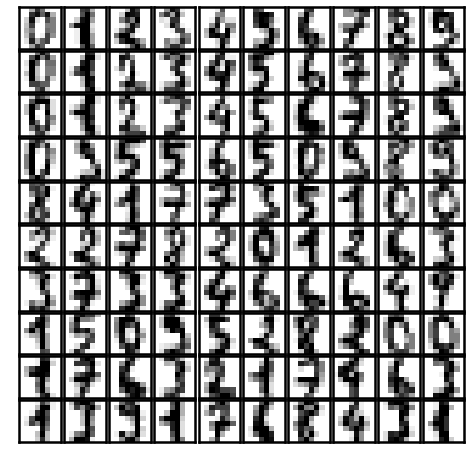

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [41]:
# ADD PCA

In [46]:
np.random.seed(0)
model = my_GMM(10)

model.fit(digits.data, it_max = 1000, tol = 10**-6);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


ValueError: array must not contain infs or NaNs

In [ ]:
%debug

> /usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py(496)asarray_chkfinite()
    494     if a.dtype.char in typecodes['AllFloat'] and not np.isfinite(a).all():
    495         raise ValueError(
--> 496             "array must not contain infs or NaNs")
    497     return a
    498 



In [38]:
digits.data.shape

(1797, 64)

In [39]:
model.labels_.shape

(2082,)

In [32]:
for k in np.unique(model.labels_): 
    print(digits.target[np.where(model.labels_==k)])

IndexError: index 1974 is out of bounds for axis 0 with size 1797